## Adapting The GPT2 for Time Series

Paper: Autoformer: Decomposition Transformers with
Auto-Correlation for Long-Term Series Forecasting




In [ ]:
import numpy as np
import pandas as pd
import math
import time
import matplotlib.pyplot as plt
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Subset
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
from typing import Tuple

torch.manual_seed(1)

In [ ]:
class TS_Handler:

    def __init__(self, df, context_length, n_predict, target_col_idx_list=[0,1,2,3,-1], test_size=0.2):
        self.context_length = context_length
        self.n_predict = n_predict
        assert self.context_length != 0
        assert self.n_predict != 0

        # Load, split without shuffle and make context length exmaples.
        self.dates = df.index
        self.ts = torch.tensor(df.values, dtype=torch.float)
        self.ts_len = len(df)
        self.ts_d = df.shape[1]
        self.target_col_idx_list = target_col_idx_list

        # 6:2:2 ratio
        self.train_ts, val_ts = train_test_split(self.ts, test_size=0.4, shuffle=False)
        self.val_ts, self.test_ts = train_test_split(val_ts, test_size=0.5, shuffle=False)

        self.X_train, self.y_train = self.make_examples(self.train_ts)
        self.X_val, self.y_val = self.make_examples(self.val_ts)
        self.X_test, self.y_test = self.make_examples(self.test_ts)

        self.train_dataset = TensorDataset(self.X_train, self.y_train)
        self.val_dataset = TensorDataset(self.X_val, self.y_val)
        self.test_dataset = TensorDataset(self.X_test, self.y_test)
        print(f"Number of training, val, and testing examples: {len(self.train_dataset)}, {len(self.val_dataset)}, {len(self.test_dataset)}")

    def pre_process_text(self):
        chars = sorted(list(set(self.raw_text)))
        vocab_size = len(chars)
        stoi = {char: i for i, char in enumerate(chars)}
        itos = {i: char for char, i in stoi.items()}
        return vocab_size, stoi, itos

    def make_examples(self, ts, verbose=False):
        n_examples = ts.shape[0] - (self.context_length + self.n_predict)
        X = torch.empty(n_examples, self.context_length, self.ts_d, dtype=torch.float)
        Y = torch.empty(n_examples, self.n_predict, len(self.target_col_idx_list), dtype=torch.float)
        future_date_features = torch.empty(n_examples, self.n_predict, 4, dtype=torch.float)

        # This will have to change for multivariate TS
        for i in range(n_examples):
            X[i] = ts[i:i+self.context_length,:]
            Y[i] = ts[i+self.context_length:i+self.context_length+self.n_predict, self.target_col_idx_list]
            # future_date_features[i] = ts[i+self.context_length:i+self.context_length+self.n_predict, :4]
            if verbose: print(f"Example {i+1:2d}: {X[i].tolist()} --> {Y[i].item()}")

        return X, Y


# Embedding The Time Series

In [ ]:
class Temporal_Embedding(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        hour_size = 24
        weekday_size = 7
        day_size = 32
        month_size = 13

        self.hour_embd = nn.Embedding(hour_size, n_embd)
        self.weekday_embd = nn.Embedding(weekday_size, n_embd)
        self.day_embd = nn.Embedding(day_size, n_embd)
        self.month_embd = nn.Embedding(month_size, n_embd)

    def forward(self, x):
        x = x.long()
        hour_embed = self.hour_embd(x[:, :, 3])
        weekday_embed = self.weekday_embd(x[:, :, 2])
        day_embed = self.day_embd(x[:, :, 1])
        month_embed = self.month_embd(x[:, :, 0])

        return hour_embed + weekday_embed + day_embed + month_embed


class TS_Embedding(nn.Module):
    def __init__(self, config , encoder):
        super().__init__()
        self.token_embd = nn.Conv1d(in_channels=config.c_in, out_channels=config.n_embd,
                                   kernel_size=3, padding=1, padding_mode='circular', bias=False)

        self.temporal_embd = Temporal_Embedding(config.n_embd)

        if encoder:
            self.positional_embd = nn.Embedding(config.context_length, config.n_embd)
        else:
            self.positional_embd = nn.Embedding(config.context_length//2 + config.n_predict, config.n_embd)
        self.dropout = nn.Dropout(config.dropout)


    def forward(self, x, temp_features):
        device = x.device
        n_graphs, n_nodes, c_in = x.size()
        positions = torch.arange(0, n_nodes, dtype=torch.long, device=device).unsqueeze(dim=0)

        token_embd = self.token_embd(x.transpose(1, 2)).transpose(1, 2)
        temporal_embd = self.temporal_embd(temp_features)
        positional_embd = self.positional_embd(positions)

        x = self.dropout(token_embd + temporal_embd + positional_embd)
        return x


# Time Series Decomposition

In [ ]:

class Moving_Avg(nn.Module):

    def __init__(self, kernel_size, stride):
        super().__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # Padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x

class Series_Decomposition(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.moving_avg = Moving_Avg(kernel_size=config.MA_window, stride=1)

    def forward(self, x):
        trend = self.moving_avg(x)
        residual = x - trend
        return residual, trend


# Auto-Correlation Attention

In [ ]:
class Auto_Correlation_Attention(nn.Module):

    def __init__(self, config, encoder, cross_attention=False):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.projection_factor = 2 if cross_attention else 3
        self.n_nodes = config.context_length if encoder else config.context_length//2 + config.n_predict
        self.top_k_factor = config.top_k_factor

        # Layer to generate keys, queries, values (if required) in one pass:
        self.project_components = nn.Linear(config.n_embd, self.projection_factor * config.n_embd)
        self.output_dropout = nn.Dropout(config.dropout)

    def forward(self, x, x_cross=None):
        device = x.device
        n_graphs, n_nodes, n_embd = x.size()


        # Implement cross attention as well as self attention.
        if x_cross is None:
            queries, keys, values  = self.project_components(x).split(self.n_embd, dim=2)
        else:
            queries, keys = self.project_components(x_cross).split(self.n_embd, dim=2)

            # match up dimensions with some zero padding
            pad = torch.zeros([n_graphs, n_nodes-queries.shape[1], n_embd], dtype=torch.float, device=device)
            queries = torch.concat([queries, pad], dim=1)
            keys = torch.concat([keys, pad], dim=1)
            values = x


        queries = queries.view(n_graphs, n_nodes, self.n_head, n_embd // self.n_head)
        keys = keys.view(n_graphs, n_nodes, self.n_head, n_embd // self.n_head)
        values = values.view(n_graphs, n_nodes, self.n_head, n_embd // self.n_head)

        # Apply the Wiener–Khinchin theorem to get auto-cov (R) for each embedding dim.
        queries_fft = torch.fft.rfft(queries.permute(0, 2, 3, 1).contiguous(), dim=-1)
        keys_fft = torch.fft.rfft(keys.permute(0, 2, 3, 1).contiguous(), dim=-1)
        power_spectrum = queries_fft * torch.conj(keys_fft)
        R = torch.fft.irfft(power_spectrum, n=n_nodes, dim=-1)

        # Pick the k larest autocorrelations:
        k = int(self.top_k_factor * math.log(n_nodes))
        top_R, lags = torch.topk(R, k=k, dim=-1)
        top_R = torch.softmax(top_R, dim=-1)

        # Roll the values, scale them by the auto_covs, add them together.
        # This is'nt nice in terms of kernels, can't use torch.roll as each item in the batch can
        # be shifted by different amounts so we need to normalise over

        # 1,2,...L for each embedded time series in each head in each batch
        ordered_idxs = torch.arange(n_nodes).unsqueeze(0).unsqueeze(0).unsqueeze(0)\
            .repeat(n_graphs, self.n_head, n_embd // self.n_head, 1).to(values.device)

        # [a,b,c] --> [a,b,c,a,b,c] for each embedding of the value so that we can do a cyclical shift (perumutaion).
        values = values.permute(0, 2, 3, 1).contiguous()
        extended_values = values.repeat(1, 1, 1, 2)
        summed_permuted_values = torch.zeros_like(values).float()


        # lags[..., i] -> Gets the ith best lag for each embedding in each head, in each batch.
        # An example for one emedding: say lag = 2
        # init_idxs + lags[..., i].unsqueeze(-1) -> [0,1,2...] -> [2,3,4....]

        for i in range(k):
            permuted_idxs = ordered_idxs + lags[..., i].unsqueeze(-1)
            # Collect the right values across the heads and batch.
            ith_rolled_values = torch.gather(extended_values, dim=-1, index=permuted_idxs)
            # Scale these by the auto-cov and sum up.
            summed_permuted_values = summed_permuted_values + ith_rolled_values * (top_R[..., i].unsqueeze(-1))

        # Concat along across the heads so in.shape = out.shape and dropout
        # out = self.output_dropout(summed_permuted_values.permute(0, 3, 1, 2).contiguous().view(n_graphs, n_nodes, n_embd)))
        out = summed_permuted_values.permute(0, 3, 1, 2).contiguous().view(n_graphs, n_nodes, n_embd)

        return out

In [ ]:
class Multi_Layer_Perceptron(nn.Module):

    def __init__(self, d_in, bias, d_out=None):
        super().__init__()
        if d_out is None: d_out = d_in
        # 4X step up as in the paper, and GeLu to stop dead neurons.
        self.fc    = nn.Linear(d_in, 4 * d_in, bias=bias)
        self.proj  = nn.Linear(4 * d_in, d_out, bias=bias)
        self.nonlin = nn.GELU()

    def forward(self, x):
        x = self.fc(x)
        x = self.nonlin(x)
        x = self.proj(x)
        return x

In [ ]:
class Encoder_Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.attn = Auto_Correlation_Attention(config, encoder=True)
        self.sd1 = Series_Decomposition(config)
        self.mlp = Multi_Layer_Perceptron(d_in=config.n_embd, bias=config.bias)
        self.sd2 = Series_Decomposition(config)
        self.drop_out = nn.Dropout(config.dropout)

    def forward(self, x):
        x = x + self.drop_out(self.attn(x))
        res2 , _ = self.sd1(x)
        x = x + self.drop_out(self.mlp(res2))
        residual, trend = self.sd2(x)
        # feed only the seasonal part into the next encoder in the stack.
        return residual

In [ ]:
class Decoder_Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.self_attn = Auto_Correlation_Attention(config, encoder=False)
        self.sd1 = Series_Decomposition(config)
        self.cross_attn = Auto_Correlation_Attention(config, encoder=False, cross_attention=True)
        self.sd2 = Series_Decomposition(config)
        self.mlp = Multi_Layer_Perceptron(d_in=config.n_embd, bias=config.bias)
        self.trend_p = nn.Linear(config.n_embd, config.c_in, bias=config.bias)
        self.sd3 = Series_Decomposition(config)
        self.drop_out = nn.Dropout(config.dropout)

    def forward(self, res, trend, res_cross):
        res = res + self.drop_out(self.self_attn(res))
        res, trend1 = self.sd1(res)
        res = res + self.cross_attn(res, res_cross)
        res, trend2 = self.sd2(res)
        res = res + self.drop_out(self.mlp(res))
        residual, trend3 = self.sd3(res)

        projected_trend = self.trend_p(trend1 + trend2 + trend3)
        trend = trend + self.drop_out(projected_trend)

        return residual, trend

In [ ]:
class TTT(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.context_length is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            sd = Series_Decomposition(config),
            enc_emb = TS_Embedding(config, encoder=True),
            dec_emb = TS_Embedding(config, encoder=False),
            encoder_stack = nn.ModuleList([Encoder_Block(config) for _ in range(config.n_encoders)]),
            decoder_stack = nn.ModuleList([Decoder_Block(config) for _ in range(config.n_decoders)])))


        self.decoder_r_proj = nn.Linear(config.n_embd, config.c_in, bias=config.bias)
        self.enc_layer_norm = nn.LayerNorm(config.n_embd)
        self.dec_layer_norm = nn.LayerNorm(config.n_embd)
        self.out_proj = nn.Linear(config.c_in, 1, bias=config.bias)
        # Print the number of parameters
        print("Number of parameters: %d" % (sum(p.nelement() for p in self.parameters()),))

    def forward(self, x, y):
        device = x.device
        n_graphs, n_nodes, c_in_w_temp = x.size()
        assert n_nodes <= self.config.context_length, f"Cannot forward sequence {seq} of length {n_nodes} as it exceeds the maximum context legnth {self.config.context_length}."


        # encoder
        en_temp_features = x[:,:,:4]
        x = x[:,:,4:]
        x_0_en = self.transformer.enc_emb(x, en_temp_features)

        x_enc = x[:,n_nodes//2:,:]
        x_en_r, x_en_t = self.transformer.sd(x_enc)
        x_0 = torch.zeros([n_graphs, self.config.n_predict, config.c_in], device=device)
        x_mean = torch.mean(x_enc, dim=1).unsqueeze(1).repeat(1, self.config.n_predict, 1)

        for encoder_block in self.transformer.encoder_stack:
            x_0_en = encoder_block(x_0_en)
        encoder_out = self.enc_layer_norm(x_0_en)

        # decoder
        x_de_r = torch.concat((x_en_r, x_0), dim=1)
        x_de_t = torch.concat((x_en_t, x_mean), dim=1)

        # this embedding needs to be changed to include temporal embeddings of the zeros. +1 % frequency of feature so it loops around ??
        future_temp = y[:,:,:4]
        de_temp_features = torch.concat((en_temp_features[:,n_nodes//2:,:], future_temp), dim=1)
        # de_temp_features = torch.concat((en_temp_features[:,n_nodes//2:,:], \
        #                                  torch.zeros([n_graphs, self.config.n_predict, c_in_w_temp - config.c_in], device=device)), dim=1)

        x_0_de = self.transformer.dec_emb(x_de_r, de_temp_features)

        for decoder_block in self.transformer.decoder_stack:
            x_0_de, x_de_t = decoder_block(x_0_de, x_de_t, encoder_out)
        decoder_t = self.dec_layer_norm(x_0_de)
        x_de_res_pred = self.decoder_r_proj(decoder_t)

        de_out = x_de_res_pred + x_de_t
        pred = de_out[:,n_nodes//2:,:]

        return pred



In [ ]:
@dataclass
class GPT_Config:
    # Default GPT-2 hyperparameters from the paper
    context_length: int = 96
    c_in: int = 1 # univariate TS
    top_k_factor: int = 1 # Paper: "we set c to the range of 1 to 3."
    MA_window: int = 25 # From paper
    n_encoders: int = 2
    n_decoders: int = 1
    n_predict: int = 96
    n_head: int = 8
    n_embd: int = 512
    dropout: float = 0.1
    bias: bool = False

In [ ]:

class Trainer:
    def __init__(self, ts_handler, save_path, optimizer_config, config=None, load_path=None, eval_interval=25):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.load_checkpoint(load_path)
        self.ts_handler = ts_handler
        self.config = config
        self.optimizer_config = optimizer_config
        self.save_path = save_path
        self.eval_interval = eval_interval
        self.lrs = []

    def load_checkpoint(self, path):
        if path is not None:
            # Load the saved model, optimiser state, and losses from checkpoint
            checkpoint = torch.load(path)
            self.config = checkpoint['config']

            self.model = TTT(config)
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.model.to(self.device)

            self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-4, weight_decay=1e-1)
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

            self.train_losses = checkpoint['train_losses']
            self.val_losses = checkpoint['val_losses']
            self.plot_loss(smoothing_window=10)

            checkpoint = None # free up memory

        else:
            # Start from scratch
            assert config is not None, "You must provide a configuration for the GPT if training from scratch."
            self.model = TTT(config)
            self.model.to(self.device)
            self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-4, weight_decay=1e-1)
            self.train_losses = []
            self.val_losses = []

    def train(self, n_epochs, bs, training_data_frac=1):
        self.model.train()
        train_loader = DataLoader(self.ts_handler.train_dataset, batch_size=bs, shuffle=True)
        n_batches = int(len(train_loader) * training_data_frac)
        print(f"Training on {n_batches}/{len(train_loader)} batches per epoch.")

        for epoch in range(1, n_epochs+1):
                for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
                    if batch_idx >= n_batches:
                        break

                    # Determine the learning rate
                    lr = self.get_lr(epoch*batch_idx) if optimizer_config.decay_lr else optimizer_config.learning_rate
                    for param_group in self.optimizer.param_groups:
                        param_group['lr'] = lr
                        self.lrs.append(lr)

                    # Forwards pass
                    X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
                    preds = self.model(X_batch, y_batch)

                    # Backwards pass
                    loss = F.mse_loss(preds.contiguous().view(-1), y_batch[:,:,-1].view(-1))
                    self.optimizer.zero_grad(set_to_none=True)
                    loss.backward()

                    if self.optimizer_config.grad_clip != 0.0:
                      torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.optimizer_config.grad_clip)

                    self.optimizer.step()

                    # Print out losses.
                    if batch_idx % self.eval_interval == 0:
                        losses = self.estimate_loss()
                        print(f"Epoch: {epoch}, Batch: {batch_idx}, Train Loss: {losses['train']:.3f}, Val Loss: {losses['val']:.3f}")

        self.plot_loss(smoothing_window=5)
        self.save_checkpoint()


    def get_lr(self, it):
      warmup_iters = self.optimizer_config.warmup_frac * self.optimizer_config.lr_decay_iters
      # 1) linear warmup for warmup_iters steps
      if it < warmup_iters:
          return self.optimizer_config.learning_rate * it / warmup_iters
      # 2) if it > lr_decay_iters, return min learning rate
      if it > self.optimizer_config.lr_decay_iters:
          return self.optimizer_config.min_lr
      # 3) in between, use cosine decay down to min learning rate
      decay_ratio = (it - warmup_iters) / (self.optimizer_config.lr_decay_iters - warmup_iters)
      assert 0 <= decay_ratio <= 1
      coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1

      return self.optimizer_config.min_lr + coeff * (self.optimizer_config.learning_rate - self.optimizer_config.min_lr)


    @torch.no_grad()
    def estimate_loss(self, n_batches=10, test=False):
        out = {}
        self.model.eval()

        if not test:
            dataset_dict = {'train': self.ts_handler.train_dataset, 'val': self.ts_handler.val_dataset}
        else:
            dataset_dict = {'test': self.ts_handler.test_dataset}

        for split, data in dataset_dict.items():
            loader = DataLoader(data, batch_size=32, shuffle=True)
            losses = torch.zeros(n_batches)
            for batch_idx, (X_batch, y_batch) in enumerate(loader):
                if batch_idx >= n_batches:
                    break
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
                preds = self.model(X_batch, y_batch)
                loss = F.mse_loss(preds.contiguous().view(-1), y_batch[:, :, -1].view(-1))
                losses[batch_idx] = loss.item()

            out[split] = losses.mean()

        if not test:
            self.train_losses.append(out['train'])
            self.val_losses.append(out['val'])

        self.model.train()
        return out



    def save_checkpoint(self):
        self.model.eval()
        torch.save({'model_state_dict': self.model.state_dict(),
                    'config': self.config,
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'train_losses': self.train_losses,
                    'val_losses': self.val_losses}, self.save_path)

    @staticmethod
    def moving_average(data, window_size):
        series = pd.Series(data)
        moving_avg = series.rolling(window=window_size).mean()
        return moving_avg.tolist()

    def plot_loss(self, smoothing_window):
        fig, ax = plt.subplots(nrows=1, ncols=2)
        for i in range(2):
            ax[i].plot(self.moving_average(self.train_losses, smoothing_window), label='train')
            ax[i].plot(self.moving_average(self.val_losses, smoothing_window), label='val')
            ax[i].legend()
        ax[1].set_yscale('log')
        ax[0].set_ylabel("Smoothed loss")
        ax[1].set_ylabel("Smoothed Logged loss")

    def plot_example(self, idx, split='test'):
      self.model.eval()
      if split == 'test':
        x = self.ts_handler.X_test[idx]
        y = self.ts_handler.y_test[idx]
      elif split == 'val':
        x = self.ts_handler.X_val[idx]
        y = self.ts_handler.y_val[idx]
      else:
        x = self.ts_handler.X_train[idx]
        y = self.ts_handler.y_train[idx]
      x = x.unsqueeze(dim=0).to(self.device)
      y = y.unsqueeze(dim=0).to(self.device)


      pred = model_trainer.model(x, y[:,:,:4]).squeeze(0).squeeze(-1).cpu().detach().numpy()

      fig, ax = plt.subplots()
      t1 = np.arange(self.config.context_length)
      t2 = np.arange(self.config.context_length, self.config.context_length + config.n_predict)
      input = x.squeeze(dim=0)[:,-1].cpu().numpy()
      actual = y.squeeze(dim=0)[:,-1].cpu().numpy()
      ax.plot(t1, input, label="input")
      ax.plot(t2, pred, label="generated")
      ax.plot(t2, actual, label="actual")
      ax.legend()



# Training

In [ ]:
url = "https://github.com/zhouhaoyi/ETDataset/raw/main/ETT-small/ETTh1.csv"
# url = "https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv"

In [ ]:
df = pd.read_csv(url, parse_dates=["date"])

In [ ]:
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.day_of_week
df['hour'] = df['date'].dt.hour
y_column = df.pop('OT')
df.insert(len(df.columns), 'OT', y_column)
df = df.set_index('date')
time_features = ['month', 'day', 'day_of_week', 'hour']
for i, name in enumerate(time_features):
  col = df.pop(name)
  df.insert(i, name, col)
other_features = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LULL','LUFL']
for i, name in enumerate(other_features):
  col = df.pop(name)
df.head()

,month,day,day_of_week,hour,OT
date,,,,,
2016-07-01 00:00:00,7,1,4,0,30.531000
2016-07-01 01:00:00,7,1,4,1,27.787001
2016-07-01 02:00:00,7,1,4,2,27.787001
2016-07-01 03:00:00,7,1,4,3,25.044001
2016-07-01 04:00:00,7,1,4,4,21.948000


In [ ]:
context_length = 96
n_predict = 96
n_temp_features = 4
ts_handler = TS_Handler(df, context_length, n_predict)

Number of training, val, and testing examples: 10306, 3338, 3338


In [ ]:
ts_handler.y_train.shape

torch.Size([10260, 96, 5])

In [ ]:
# ts_handler.X_train[0][:,:4], ts_handler.y_train[0][:,:4]

In [ ]:
@dataclass
class Optimizer_Config:
  learning_rate: float = 8e-4 # max learning rate
  weight_decay: float = 1e-1
  beta1: float = 0.9
  beta2: float = 0.999
  grad_clip: bool = 1.0 # gradients clipped at this value, disable with == 0.0
  decay_lr: bool = False
  warmup_frac: float = 0.03 # To increase the lr slowly.
  lr_decay_iters: int = 1 # update to 10 epochs * n_batches in an epoch
  min_lr: float = 6e-6

In [ ]:
# Train setup
save_path = 'Ts_GPT.pth'
# load_path = 'Ts_GPT.pth'
load_path = None

config = GPT_Config(
    context_length = context_length,
    c_in = ts_handler.ts_d - n_temp_features,
    top_k_factor = 1,
    MA_window = 25,
    n_encoders = 2,
    n_decoders = 1,
    n_predict = n_predict,
    n_head = 8,
    n_embd = 256,
    dropout = 0.05,
    bias = False)

optimizer_config = Optimizer_Config(
    lr_decay_iters = 10*321
)

model_trainer = Trainer(ts_handler, save_path, optimizer_config, config, load_path)


Number of parameters: 2388225


In [ ]:
bs = 32
training_data_frac = 1
n_epochs = 20 # /10
model_trainer.train(n_epochs, bs, training_data_frac)

Training on 323/323 batches per epoch.
Epoch: 1, Batch: 0, Train Loss: 22.380, Val Loss: 14.858
Epoch: 1, Batch: 25, Train Loss: 9.973, Val Loss: 8.027
Epoch: 1, Batch: 50, Train Loss: 10.975, Val Loss: 8.830
Epoch: 1, Batch: 75, Train Loss: 10.523, Val Loss: 9.883
Epoch: 1, Batch: 100, Train Loss: 8.154, Val Loss: 9.083
Epoch: 1, Batch: 125, Train Loss: 7.661, Val Loss: 8.613
Epoch: 1, Batch: 150, Train Loss: 9.178, Val Loss: 8.008
Epoch: 1, Batch: 175, Train Loss: 7.872, Val Loss: 9.539
Epoch: 1, Batch: 200, Train Loss: 7.061, Val Loss: 9.402
Epoch: 1, Batch: 225, Train Loss: 6.905, Val Loss: 9.523
Epoch: 1, Batch: 250, Train Loss: 7.324, Val Loss: 9.829
Epoch: 1, Batch: 275, Train Loss: 6.552, Val Loss: 9.276
Epoch: 1, Batch: 300, Train Loss: 8.527, Val Loss: 10.797
Epoch: 2, Batch: 0, Train Loss: 9.865, Val Loss: 13.187
Epoch: 2, Batch: 25, Train Loss: 8.619, Val Loss: 10.175
Epoch: 2, Batch: 50, Train Loss: 7.011, Val Loss: 9.425
Epoch: 2, Batch: 75, Train Loss: 6.768, Val Loss: 8

In [ ]:
@torch.no_grad()
def estimate_loss_w_mean(n_batches=10, test=False):
    out = {}

    if not test:
        dataset_dict = {'train': ts_handler.train_dataset, 'val': ts_handler.val_dataset}
    else:
        dataset_dict = {'test': ts_handler.test_dataset}

    for split, data in dataset_dict.items():
        loader = DataLoader(data, batch_size=32, shuffle=True)
        losses = torch.zeros(n_batches)
        for batch_idx, (X_batch, y_batch) in enumerate(loader):
            if batch_idx >= n_batches:
                break
            X_batch, y_batch = X_batch.to('cuda'), y_batch.to('cuda')
            trend = torch.mean(X_batch, dim=1)
            target = y_batch[:, :, -1]
            loss = F.mse_loss(trend[:,-1].unsqueeze(-1).expand_as(target), target)
            losses[batch_idx] = loss.item()

        out[split] = losses.mean()
    return out

estimate_loss_w_mean(n_batches=300, test=True)

{'test': tensor(3.3958)}

In [ ]:
for param_group in model_trainer.optimizer.param_groups:
            param_group['lr'] = 6e-4

In [ ]:
# plt.plot(model_trainer.lrs)

In [ ]:
model_trainer.estimate_loss(test=True, n_batches=50)

{'test': tensor(14.1128)}

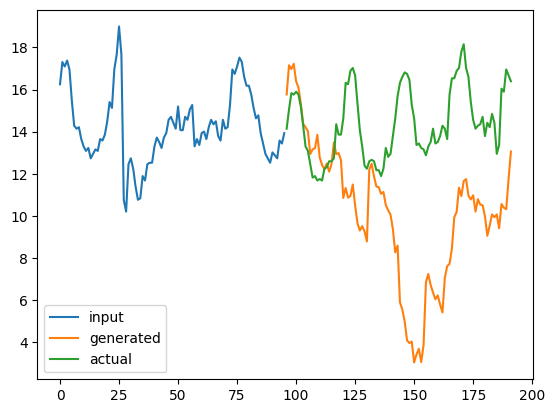

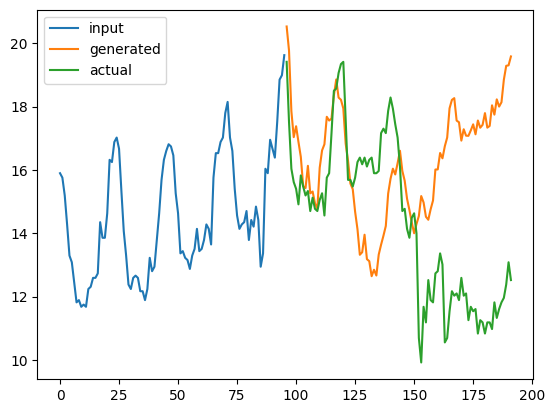

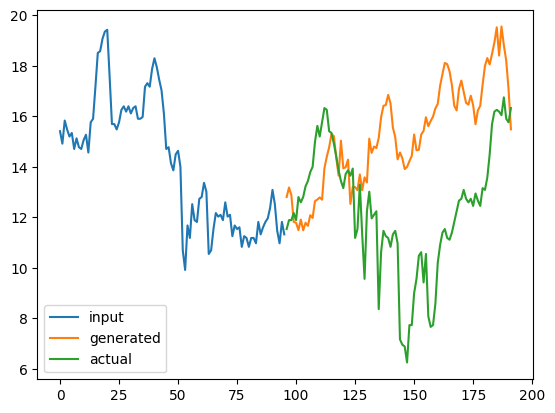

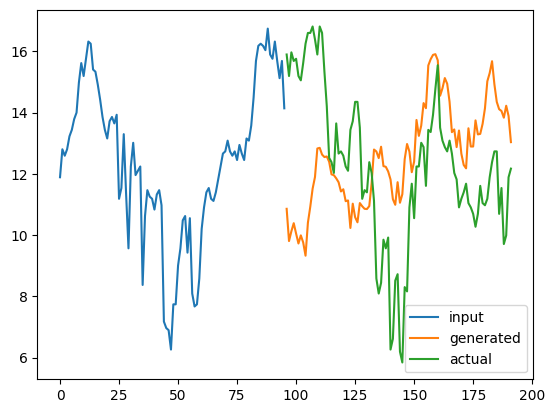

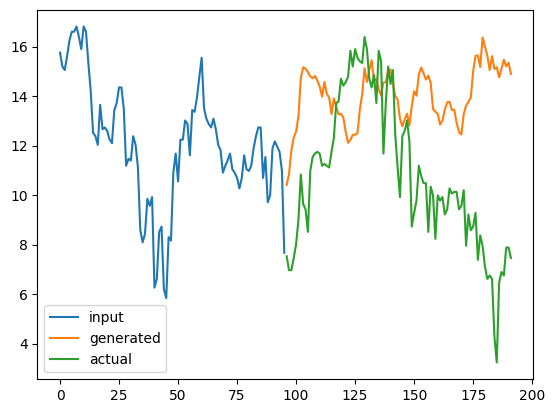

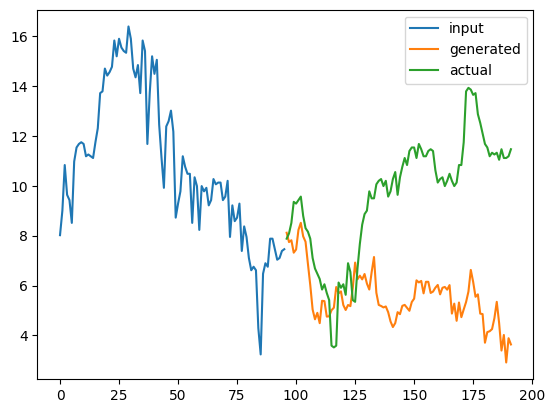

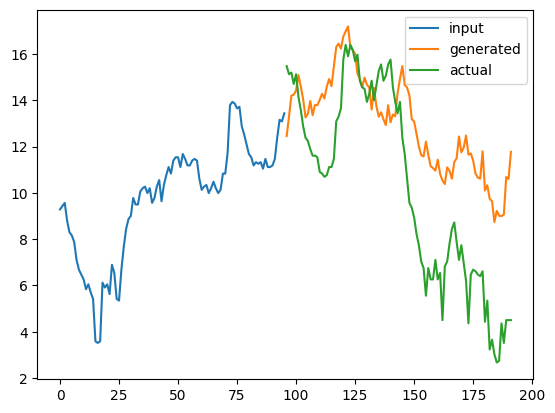

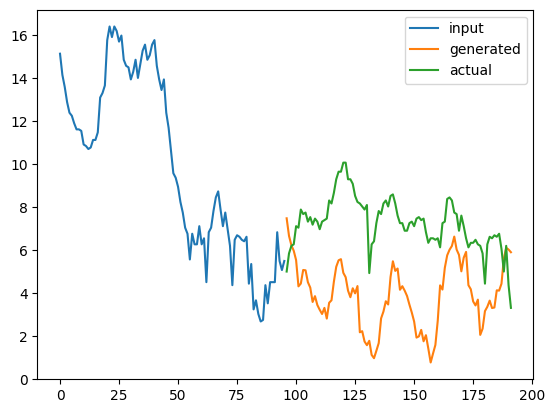

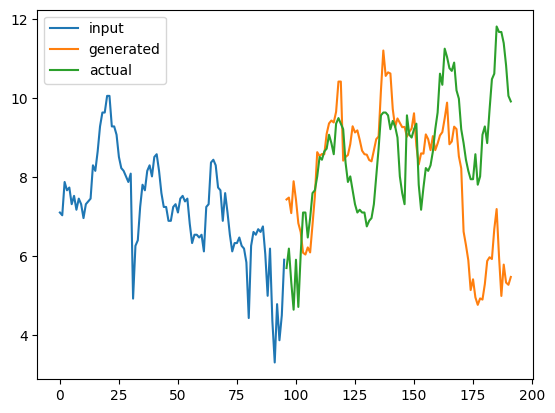

In [ ]:
for i in range(1, 900, 100):
  model_trainer.plot_example(split='val', idx=i)

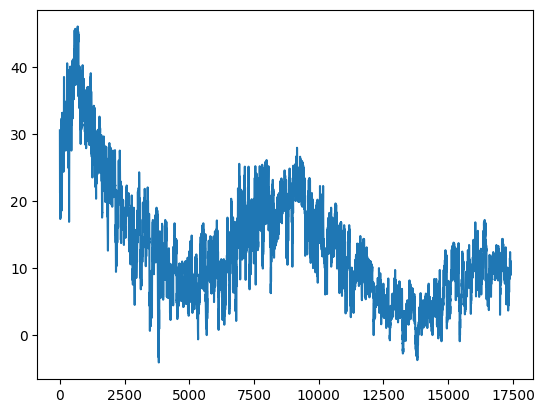

In [ ]:
plt.plot(ts_handler.ts[:,-1])

In [ ]:
# from google.colab import files
# import os
# directory = 'C:/Users/adamm/OneDrive/Documents'
# filename = save_path
# file_path = os.path.join(directory, filename)
# files.download(save_path, path=file_path)